# The Battle of Neighborhoods

### *Import necessary Libraries*

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

### *Data Collection*

#### The rental data of Bangalore is collected from www.makaan.com website. The complete dataset is available in 85 webpages. Data scraping from these multiple webpages is done using BeautifulSoup.

In [57]:
# Run the 1st webpage through BeautifulSoup and check the structure of the webpage.

source = requests.get('https://www.makaan.com/price-trends/property-rates-for-rent-in-bangalore').text
soup = BeautifulSoup(source, 'html.parser')
# print(soup.prettify())

In [58]:
# Extracting the rental data from the 1st webpage and transforming it into a Pandas Dataframe.

rent_table = soup.find("table", attrs={"class": "tbl"})
    
rent_data = [[cell.text for cell in row.find_all(["th","td"])]
                        for row in rent_table.find_all("tr")]

df_rent = pd.DataFrame(rent_data)

In [59]:
# Run a loop to extract the data from rest of the applicable webpages and append the data to "df_rent".

for page in range(2,86):
    source1 = requests.get('https://www.makaan.com/price-trends/property-rates-for-rent-in-bangalore?page='+str(page)).text
    soup1 = BeautifulSoup(source1, 'html.parser')
    rent_table1 = soup1.find("table", attrs={"class": "tbl"})
    
    rent_data1 = [[cell.text for cell in row.find_all(["th","td"])]
                        for row in rent_table1.find_all("tr")]

    df_rent1 = pd.DataFrame(rent_data1)
    df_rent=df_rent.append(df_rent1,ignore_index=True)

df_rent.head()

,0,1,2,3,4,5,6
0,Locality Name,Rental Rates,None,None,None,None,None
1,"{""city"":""Bangalore"",""typeAheadType"":""locality""...",1 BHk,2 BHK,3 BHK,None,None,None
2,Rent range,Avg rent,Rent range,Avg rent,Rent range,Avg rent,None
3,HSR Layout,"5,750 - 40,000","17,662.94","17,000 - 50,000","26,700","32,000 - 1.2 L","58,46.51"
4,Koramangala,"7,000 - 45,000","17,144.21","14,000 - 60,000","29,525.64","23,000 - 1.2 L","53,621.62"


In [60]:
# Assign meaningful column names.

df_rent.columns=['Locality','1BHK_Rent_Range','1BHK_Avg_Rent','2BHK_Rent_Range','2BHK_Avg_Rent','3BHK_Rent_Range','3BHK_Avg_Rent']
df_rent.head()

,Locality,1BHK_Rent_Range,1BHK_Avg_Rent,2BHK_Rent_Range,2BHK_Avg_Rent,3BHK_Rent_Range,3BHK_Avg_Rent
0,Locality Name,Rental Rates,None,None,None,None,None
1,"{""city"":""Bangalore"",""typeAheadType"":""locality""...",1 BHk,2 BHK,3 BHK,None,None,None
2,Rent range,Avg rent,Rent range,Avg rent,Rent range,Avg rent,None
3,HSR Layout,"5,750 - 40,000","17,662.94","17,000 - 50,000","26,700","32,000 - 1.2 L","58,46.51"
4,Koramangala,"7,000 - 45,000","17,144.21","14,000 - 60,000","29,525.64","23,000 - 1.2 L","53,621.62"


In [61]:
# Drop the rows which do not have the locality or rental rates data (For example: The 1st 3 rows in df_rent dataframe).
df_rent.drop(df_rent[(df_rent['1BHK_Rent_Range']=='Rental Rates')|(df_rent['1BHK_Rent_Range']=='1 BHk')|(df_rent['1BHK_Rent_Range']=='Avg rent')].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)

# Drop the columns which have the rental rate range values. We will use only the average rental rates.
df_rent.drop(['1BHK_Rent_Range','2BHK_Rent_Range','3BHK_Rent_Range'],axis=1,inplace=True)

# Drop the rows which do not have data in any of the 1BHK, 2BHK or 3BHK columns.
df_rent.drop(df_rent[(df_rent['1BHK_Avg_Rent']=='-')|(df_rent['2BHK_Avg_Rent']=='-')|(df_rent['3BHK_Avg_Rent']=='-')].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)

df_rent.head()

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent
0,HSR Layout,"17,662.94","26,700","58,46.51"
1,Koramangala,"17,144.21","29,525.64","53,621.62"
2,Whitefield,"13,416.07","18,346.65","37,33.33"
3,Krishnarajapura,"13,212.5","15,176.47","60,500"
4,Begur,"9,600","14,681.25","22,100"


In [62]:
geolocator = Nominatim(user_agent="bangalore_explorer")

df_rent['Latitude'] = df_rent['Locality'].apply(lambda x: geolocator.geocode(x).latitude if geolocator.geocode(x) != None else 'NF')
df_rent['Longitude'] = df_rent['Locality'].apply(lambda x: geolocator.geocode(x).longitude if geolocator.geocode(x) != None else 'NF')
df_rent

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude
0,HSR Layout,"17,662.94","26,700","58,46.51",12.9116,77.6389
1,Koramangala,"17,144.21","29,525.64","53,621.62",13.2924,77.7519
2,Whitefield,"13,416.07","18,346.65","37,33.33",44.3731,-71.6119
3,Krishnarajapura,"13,212.5","15,176.47","60,500",12.0325,76.8056
4,Begur,"9,600","14,681.25","22,100",41.9542,3.20883
5,Varthur,"8,787","14,400","74,000",12.9406,77.747
6,Devanahalli,"18,000","15,285.71","22,000",13.2484,77.7134
7,Chandapura,"9,120","11,466.67","16,000",17.4436,77.4334
8,Mahadevapura,"11,205.26","17,521.43","35,000",12.9935,77.6924
9,Whitefield Hope Farm Junction,"9,250","16,000","36,580.77",12.9829,77.7533


In [63]:
# Drop the rows for which latitude and longitude data are not available.
df_rent.drop(df_rent[(df_rent['Latitude']=='NF')|(df_rent['Longitude']=='NF')].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)

df_rent.shape

(203, 6)

In [64]:
# Drop any outliers.
df_rent.drop(df_rent[(df_rent['Latitude']<12.80)|(df_rent['Latitude']>13.11)|(df_rent['Longitude']<77.48)|(df_rent['Longitude']>77.78)].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)

df_rent.shape

(126, 6)

In [94]:
# Drop rows where rental data do not appear to be in accordance with other rows.
df_rent.drop(df_rent[(df_rent['Locality']=='HSR Layout')|(df_rent['Locality']=='Bellandur')|(df_rent['Locality']=='Murugeshpalya')|(df_rent['Locality']=='Thanisandra')|(df_rent['Locality']=='Subramanyapura')|(df_rent['Locality']=='Kadugodi')|(df_rent['Locality']=='Kasturi Nagar')|(df_rent['Locality']=='J. P. Nagar')|(df_rent['Locality']=='Yemalur')|(df_rent['Locality']=='Doddanekundi')|(df_rent['Locality']=='NRI Layout')].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)

df_rent.shape

(115, 6)

In [110]:
# The code was removed by Watson Studio for sharing.

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude
0,Varthur,8787.00,14400.00,74000.00,12.9406,77.7470
1,Mahadevapura,11205.26,17521.43,35000.00,12.9935,77.6924
2,Whitefield Hope Farm Junction,9250.00,16000.00,36580.77,12.9829,77.7533
3,Budigere Cross,22000.00,19000.00,19500.00,13.0464,77.7503
4,Jakkur,12666.67,16475.00,43000.00,13.0785,77.6069


In [65]:
# Get geographical coordinates of Bangalore.
address = 'Bangalore'

geolocator = Nominatim(user_agent="bangalore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


In [114]:
# Create map of Bangalore using latitude and longitude values
map_bnglr = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to map
for lat, lng, locality in zip(df_data['Latitude'], df_data['Longitude'], df_data['Locality']):
    label = folium.Popup(locality, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bnglr)  
    
map_bnglr

In [115]:
import matplotlib as mpl
import matplotlib.pyplot as plt

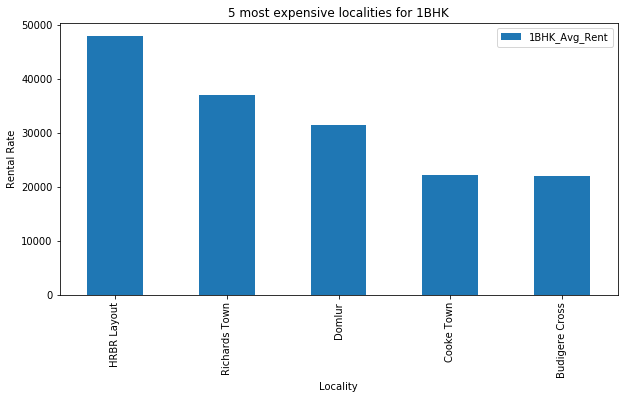

In [126]:
df_1BHK_High=df_data.nlargest(5,'1BHK_Avg_Rent')

df_1BHK_High.plot(x='Locality',y='1BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 most expensive localities for 1BHK') # add title to the plot

plt.show()

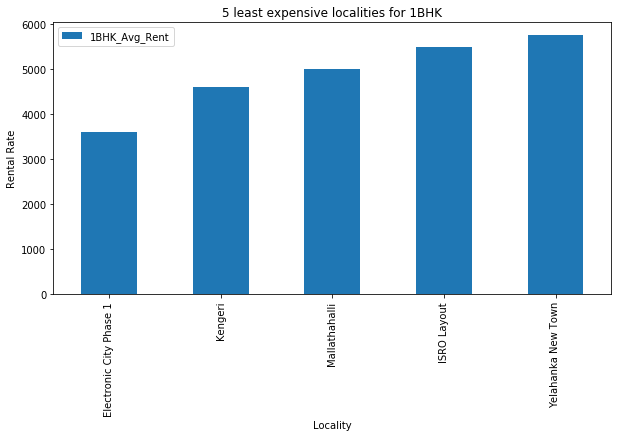

In [127]:
df_1BHK_Low=df_data.nsmallest(5,'1BHK_Avg_Rent')

df_1BHK_Low.plot(x='Locality',y='1BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 least expensive localities for 1BHK') # add title to the plot

plt.show()

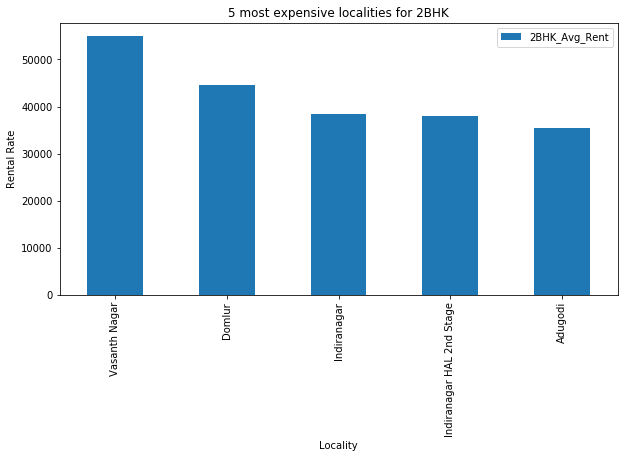

In [128]:
df_2BHK_High=df_data.nlargest(5,'2BHK_Avg_Rent')

df_2BHK_High.plot(x='Locality',y='2BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 most expensive localities for 2BHK') # add title to the plot

plt.show()

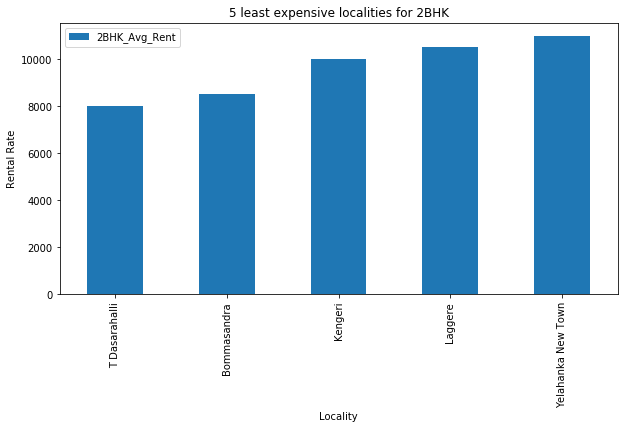

In [129]:
df_2BHK_Low=df_data.nsmallest(5,'2BHK_Avg_Rent')

df_2BHK_Low.plot(x='Locality',y='2BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 least expensive localities for 2BHK') # add title to the plot

plt.show()

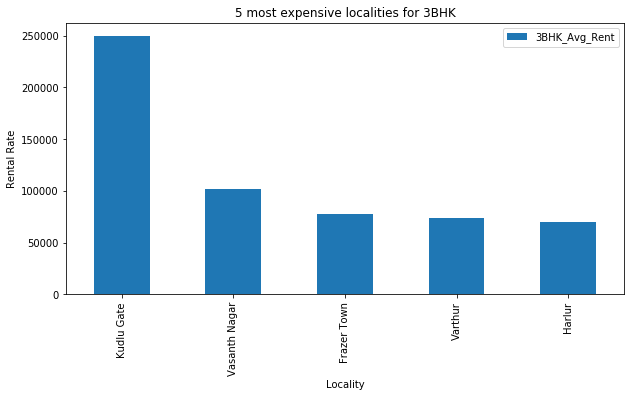

In [130]:
df_3BHK_High=df_data.nlargest(5,'3BHK_Avg_Rent')

df_3BHK_High.plot(x='Locality',y='3BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 most expensive localities for 3BHK') # add title to the plot

plt.show()

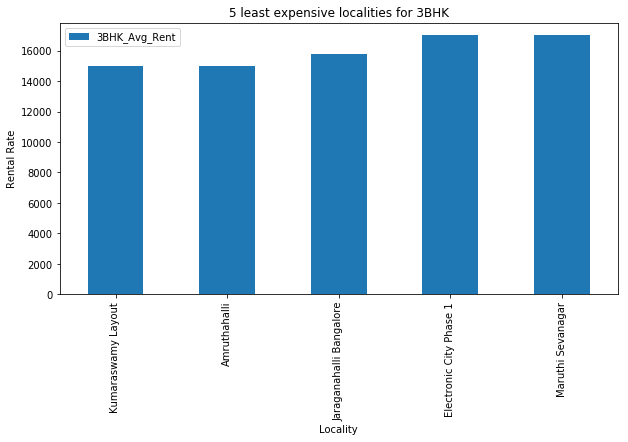

In [131]:
df_3BHK_Low=df_data.nsmallest(5,'3BHK_Avg_Rent')

df_3BHK_Low.plot(x='Locality',y='3BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 least expensive localities for 3BHK') # add title to the plot

plt.show()